In [1]:
%load_ext autoreload
%autoreload 2

# Pascal Darknet Detection
> Performing bounding box detection on PASCAL VOC 2007 using Darknet

In [2]:
#| export
from minai import *

import torch
import torch.nn as nn
from torch import tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision.transforms.v2.functional as TF
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import v2

from torcheval.metrics import MulticlassAccuracy

import fastcore.all as fc
from fastcore.utils import L
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from datasets import load_dataset, load_dataset_builder

from IPython.display import display, Image

from pilus_project.core import *
from pilus_project.darknet import *
from pilus_project.pascal_class import *

In [3]:
from torchvision.utils import draw_bounding_boxes
from torchvision import tv_tensors

Using PyTorch transforms v2 [tutorial](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py) for bounding boxes. Learn more there.


In [4]:
# Code from https://github.com/pytorch/vision/blob/main/gallery/transforms/helpers.py

import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [5]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

## Data

### Data loading

In [6]:
set_seed(42)

In [7]:
data_path = fc.Path.home()/'data/'
data_path.ls()

(#3) [Path('/home/kappa/data/VOCtrainval_06-Nov-2007.tar'),Path('/home/kappa/data/VOCdevkit'),Path('/home/kappa/data/pili')]

In [8]:
trn_ds, val_ds = create_voc_datasets(data_path)
trn_ds

Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /home/kappa/data
    StandardTransform
Transform: Compose(
                 RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [9]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, )
#     target_transform=voc_extract(field='bndbox'))
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

## Data

### Dataset

Using `TVTensors`, it is easy to create a dataset with bounding boxes. It is smart enough to apply which transform to perform based on the type.

More on [TVTensors](https://pytorch.org/vision/stable/auto_examples/transforms/plot_tv_tensors.html#sphx-glr-auto-examples-transforms-plot-tv-tensors-py).

In [10]:
# Might be useful transform..
# transforms = v2.Compose([
#     v2.RandomResizedCrop(size=(224, 224), antialias=True),
#     v2.RandomPhotometricDistort(p=1),
#     v2.RandomHorizontalFlip(p=1),
# ])

**Antialiasing**

Antialiasing helps prevent visual artifacts that occur when resizing images to smaller dimensions. When you downsample an image without antialiasing, high-frequency details can create jagged edges, moiré patterns, and other visual artifacts.

Here's what antialiasing does:

1. It applies a low-pass filter (typically a Gaussian blur) before downsampling to remove high-frequency components that would cause aliasing

2. This results in smoother transitions and reduced jagged edges in the resized image

3. It's particularly important when working with images containing fine details, text, or regular patterns

Setting `antialias=True` (the default in newer PyTorch versions) produces higher quality downsampled images but may be slightly slower. For most deep learning applications, using antialiasing is recommended because:

1. It provides more consistent and visually pleasing inputs to your model

2. It can reduce misleading high-frequency artifacts that might confuse the model

3. The small performance cost is usually negligible compared to the benefits in image quality

The only time you might want to disable it (`antialias=False`) is if:

1. You're extremely performance-sensitive and processing millions of images
2. You're trying to exactly reproduce results from older code that didn't use antialiasing
3. You specifically want to preserve certain high-frequency information for your particular task


We have to use `wrap_dataset_for_transforms_v2` on the dataset to use `TVTensors` on older datasets.

In [11]:
from torchvision.datasets import wrap_dataset_for_transforms_v2

Code from https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_e2e.html#sphx-glr-auto-examples-transforms-plot-transforms-e2e-py.

In [12]:
transforms = v2.Compose(
    [
#         v2.Resize((224, 224)),
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # zoomout is weird. do resize intead.
        v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [13]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, transforms=transforms)
ds = wrap_dataset_for_transforms_v2(ds)
im, boxes = ds[0]
im, boxes

(Image([[[0.3529, 0.3490, 0.3490,  ..., 0.9294, 0.9255, 0.9373],
         [0.3569, 0.3647, 0.3373,  ..., 1.0000, 1.0000, 1.0000],
         [0.3529, 0.3647, 0.3686,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0039, 0.0000, 0.0275,  ..., 0.0000, 0.0157, 0.1020],
         [0.0392, 0.0000, 0.0000,  ..., 0.0157, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
        [[0.3529, 0.3490, 0.3490,  ..., 0.8745, 0.8784, 0.9098],
         [0.3569, 0.3647, 0.3373,  ..., 1.0000, 1.0000, 1.0000],
         [0.3804, 0.3647, 0.3686,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0078, 0.0784],
         [0.0314, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],
 
        [[0.3176, 0.3255, 0.3255,  ..., 0.9490, 0.9490, 0.9647],
         [0.3255, 0.3412, 0.3059,  ..., 1.0000, 1.0000, 1.0000],
         [0.3294, 0.3294, 0.3373,  ..., 1.0000, 1.0000, 

By using TVTensors, boxes and labels are automatically retrieved!

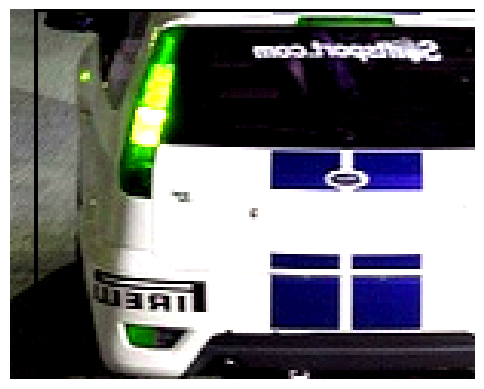

In [14]:
box_im = draw_bounding_boxes(im, boxes['boxes'])
show_image(box_im);

### DataLoader

In [64]:
set_seed(52)
trn_ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, transforms=transforms)
trn_ds = wrap_dataset_for_transforms_v2(trn_ds)
val_ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='val', download=False, transforms=transforms)
val_ds = wrap_dataset_for_transforms_v2(val_ds)

In [65]:
bs = 64

# We need a custom collation function here, since the object detection
# models expect a sequence of images and target dictionaries. The default
# collation function tries to torch.stack() the individual elements,
# which fails in general for object detection, because the number of bounding
# boxes varies between the images of the same batch.
trn_dl, val_dl = get_dls(trn_ds, val_ds, bs=bs, collate_fn=lambda batch: tuple(zip(*batch)),)
xb, yb = next(iter(trn_dl))

In [66]:
def lbl_to_nm(lbl):
    """Convert numeric class label to string names. Pytorch datasets use labels with 1-index."""
    return VOC_CLASSES[lbl['labels']-1]

In [67]:
lbl_to_nm(yb[0])

(#2) ['train','train']

In [68]:
def mk_boxs(x,y): 
    """Create an image with boxes."""
    return draw_bounding_boxes(x, y['boxes'], labels=lbl_to_nm(y))

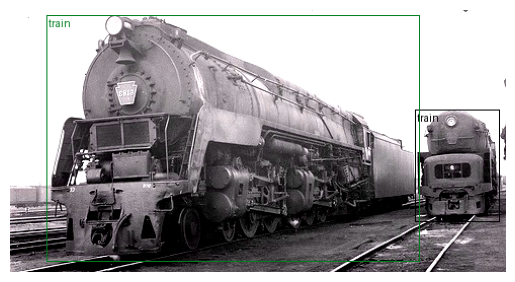

In [69]:
show_image(mk_boxs(xb[0], yb[0]));

### Eval

In [15]:
# # Function to evaluate detection results
# def evaluate_detection(model, dataloader, iou_threshold=0.5):
#     "Evaluate detection model using mAP"
#     from torchvision.ops import box_iou
    
#     model.eval()
#     all_preds = []
#     all_targets = []
    
#     with torch.no_grad():
#         for images, targets in dataloader:
#             images = images.to(def_device)
#             predictions = model(images)
            
#             # Move predictions to CPU
#             for i in range(len(predictions)):
#                 pred = {k: v.cpu() for k, v in predictions[i].items()}
#                 all_preds.append(pred)
#                 all_targets.append(targets[i])
    
#     # Calculate mAP
#     # This is a simplified version - a full implementation would use the COCO API
#     aps = []
#     for class_idx in range(len(VOC_CLASSES)):
#         precisions = []
#         recalls = []
        
#         for pred, target in zip(all_preds, all_targets):
#             # Get predictions and targets for this class
#             pred_boxes = pred['boxes'][pred['labels'] == class_idx]
#             pred_scores = pred['scores'][pred['labels'] == class_idx]
#             target_boxes = target['boxes'][target['labels'] == class_idx]
            
#             if len(target_boxes) == 0:
#                 continue
                
#             if len(pred_boxes) == 0:
#                 precisions.append(0)
#                 recalls.append(0)
#                 continue
            
#             # Sort predictions by score
#             sorted_idx = torch.argsort(pred_scores, descending=True)
#             pred_boxes = pred_boxes[sorted_idx]
            
#             # Calculate IoU
#             ious = box_iou(pred_boxes, target_boxes)
            
#             # Calculate precision and recall
#             tp = (ious > iou_threshold).any(dim=1).float()
#             fp = 1 - tp
            
#             tp_cumsum = torch.cumsum(tp, dim=0)
#             fp_cumsum = torch.cumsum(fp, dim=0)
            
#             precision = tp_cumsum / (tp_cumsum + fp_cumsum)
#             recall = tp_cumsum / len(target_boxes)
            
#             precisions.append(precision)
#             recalls.append(recall)
        
#         # Calculate AP
#         if precisions and recalls:
#             # Simplified AP calculation
#             ap = sum([p * r for p, r in zip(precisions, recalls)]) / len(precisions)
#             aps.append(ap)
    
#     return sum(aps) / len(aps) if aps else 0

# # Evaluate the model
# mAP = evaluate_detection(learn.model, detection_dls.valid)
# print(f"mAP: {mAP:.4f}")

In [16]:
# import torch
# import torch.nn as nn

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3):
#         super().__init__()
#         padding = 1 if kernel_size == 3 else 0
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.leaky = nn.LeakyReLU(0.1)

#     def forward(self, x): return self.leaky(self.bn(self.conv(x)))

# class Darknet19(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             # Initial layers
#             ConvBlock(3, 32),
#             nn.MaxPool2d(2),
#             ConvBlock(32, 64),
#             nn.MaxPool2d(2),
            
#             # First block
#             ConvBlock(64, 128),
#             ConvBlock(128, 64, kernel_size=1),
#             ConvBlock(64, 128),
#             nn.MaxPool2d(2),
            
#             # Second block
#             ConvBlock(128, 256),
#             ConvBlock(256, 128, kernel_size=1),
#             ConvBlock(128, 256),
#             nn.MaxPool2d(2),
            
#             # Third block
#             ConvBlock(256, 512),
#             ConvBlock(512, 256, kernel_size=1),
#             ConvBlock(256, 512),
#             ConvBlock(512, 256, kernel_size=1),
#             ConvBlock(256, 512),
#             nn.MaxPool2d(2),
            
#             # Fourth block
#             ConvBlock(512, 1024),
#             ConvBlock(1024, 512, kernel_size=1),
#             ConvBlock(512, 1024),
#             ConvBlock(1024, 512, kernel_size=1),
#             ConvBlock(512, 1024)
#         )

#     def forward(self, x): return self.features(x)


In [17]:
# class YOLOv2(nn.Module):
#     def __init__(self, num_classes, num_anchors=5):
#         super().__init__()
#         self.backbone = Darknet19()
        
#         # Passthrough layer from earlier feature map
#         self.passthrough_conv = ConvBlock(512, 64, kernel_size=1)
        
#         # Detection head
#         self.detection = nn.Sequential(
#             ConvBlock(1024 + 256, 1024),  # +256 from passthrough (64*4)
#             nn.Conv2d(1024, num_anchors * (5 + num_classes), kernel_size=1)
#         )
        
#     def reorg_layer(self, x):
#         # Reorganize 26x26x64 to 13x13x256
#         batch_size, channels, height, width = x.size()
#         x = x.view(batch_size, channels, height//2, 2, width//2, 2)
#         x = x.permute(0, 1, 3, 5, 2, 4)
#         x = x.contiguous().view(batch_size, channels*4, height//2, width//2)
#         return x

#     def forward(self, x):
#         # Get backbone features
#         for i, layer in enumerate(self.backbone.features):
#             x = layer(x)
#             if i == 13:  # Save feature map for passthrough
#                 passthrough = self.passthrough_conv(x)
#                 passthrough = self.reorg_layer(passthrough)
        
#         # Concatenate passthrough with final features
#         x = torch.cat([passthrough, x], dim=1)
        
#         # Detection head
#         return self.detection(x)
